# Stommel-Arons model
**03 May 2023 by MiniUFO**

---

[TOC]

---

## 1. Introduction
The abyssal circulation over the global ocean has also been explored by Stommel in a series of papers ([**Stommel 1958**](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/TR029i002p00202); [**Stommel and Arons 1960a**](https://www.sciencedirect.com/science/article/abs/pii/0146631359900656), [**1960b**](https://www.sciencedirect.com/science/article/abs/pii/0146631359)).  The model is a special form of Gill-Matsuno model.  Given a mass source (divergence) at the North Atlantic and Antarctic, and assuming everywhere else is uniform upwelling or mass sink (convergence), the horizontal abyssal circulation can be quantitatively reproduced.  This is called Stommel-Arons model.


## 2. Theory
For a homogeneous quasi-horizontal ocean, the starting point should be the shallow-water equations:

$$
\begin{align}
\frac{\partial \mathbf u}{\partial t}&=-\left(\mathbf{u}\cdot\nabla\right)\mathbf u-g\nabla h-f\hat{\mathbf u}\tag{1}\\
\frac{\partial h}{\partial t}&=-\nabla\cdot\left(h\mathbf u\right)\tag{2}
\end{align}
$$

Assuming that the ocean flow is in steady state with flat bottom, ignoring the nonlinear terms, and add a mass source/sink forcing, one gets:

$$
\begin{align}
g\nabla h&=-f\hat{\mathbf u}\tag{3}\\
\nabla \cdot\mathbf u&=Q\tag{4}
\end{align}
$$

[Stommel and Arons (1960a)](https://www.sciencedirect.com/science/article/abs/pii/0146631359900656) solved the above simplified model directly once $Q$ is given.  It is clear that this is a special form of Gill-Matsuno model when their linear damping coefficient $\epsilon=0$.  But Gill-Matsuno model cannot be solved using `xinvert` when $\epsilon=0$, because it is no longer a second-order PDE suitable.  Following Gill-Matsuno model, we can add a linear damping term in the momentum equations but neglect the one in the continuity equation:

$$
\begin{align}
g\nabla h&=-f\hat{\mathbf u} + \epsilon \mathbf u\tag{5}
\end{align}
$$

Then the solutions is similar to Gill-Matsuno model as:

$$
\begin{align}
\nabla\cdot\left(c_1\nabla h-c_2\hat\nabla h\right)&= Q \tag{6} \\
u &= -c_1 g\frac{\partial h}{\partial x}-c_2 g\frac{\partial h}{\partial y}\tag{7}\\
v &= -c_1 g\frac{\partial h}{\partial y}+c_2 g\frac{\partial h}{\partial x} \tag{8}
\end{align}
$$

where $\nabla=(\partial_x, \partial_y)$, $\hat\nabla=(-\partial_y, \partial_x)$, $c_1=\epsilon/(\epsilon^2+f^2)$ and $c_2=f/(\epsilon^2+f^2)$.

## 3. Examples
### 3.1 Basin case

[**Stommel and Arons (1960)**](https://www.sciencedirect.com/science/article/abs/pii/0146631359900656) has demonstrated many cases.  The first one is in an idealized ocean basin over northern hemisphere.

In [2]:
#%% first case in a basin
import sys
sys.path.append('../../../')
import numpy as np
import xarray as xr
from xinvert import invert_StommelArons, invert_Poisson, cal_flow

def add_source(msrc, olon, olat, amp, rad):
    lons = msrc.lon
    lats = msrc.lat
    msrc += amp * np.exp(-((lats-olat)**2/rad + (lons-olon)**2/rad/3))

lons = xr.DataArray(np.linspace(0, 360, 720), dims='lon', coords={'lon':np.linspace(0, 360, 720)})
lats = xr.DataArray(np.linspace(0, 88, 177), dims='lat', coords={'lat':np.linspace(0, 88, 177)})

lats, lons = xr.broadcast(lats, lons)

basin = np.logical_and(lons< 210, lons>120)
msrc1 = lats - lats
msrc1 = xr.where(basin, 0, np.nan) # maskout a basin
add_source(msrc1, 125,  87, -6e-3, 1)

msrc2 = msrc1.copy().load()
add_source(msrc2, 210,  65, -6e-3, 1)
add_source(msrc2, 210,  25,  6e-3, 1)

In [5]:
from xinvert import FiniteDiff, invert_Poisson

fd = FiniteDiff({'X':'lon', 'Y':'lat'}, BCs='extend')

f = 2 * 7.292e-5 * np.sin(np.deg2rad(msrc1.lat))
beta = 2 * 7.292e-5 * np.cos(np.deg2rad(msrc1.lat)) / 6371200.0

Q1 = fd.grad(msrc1, dims='X') * f**2 / -beta
Q2 = fd.grad(msrc2, dims='X') * f**2 / -beta

iParams = {
    'BCs'      : ['extend', 'extend'],
    'mxLoop'   : 5000,
    'optArg'   : 1,
    'tolerance': 1e-18,
    'undef'    : np.nan,
}

h1 = invert_Poisson(Q1, dims=['lat','lon'], iParams=iParams)
h2 = invert_Poisson(Q2, dims=['lat','lon'], iParams=iParams)

{} loops 5000 and tolerance is 9.424018e-05
{} loops 5000 and tolerance is 6.808629e-05


C:\ProgramData\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\ProgramData\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\ProgramData\anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))


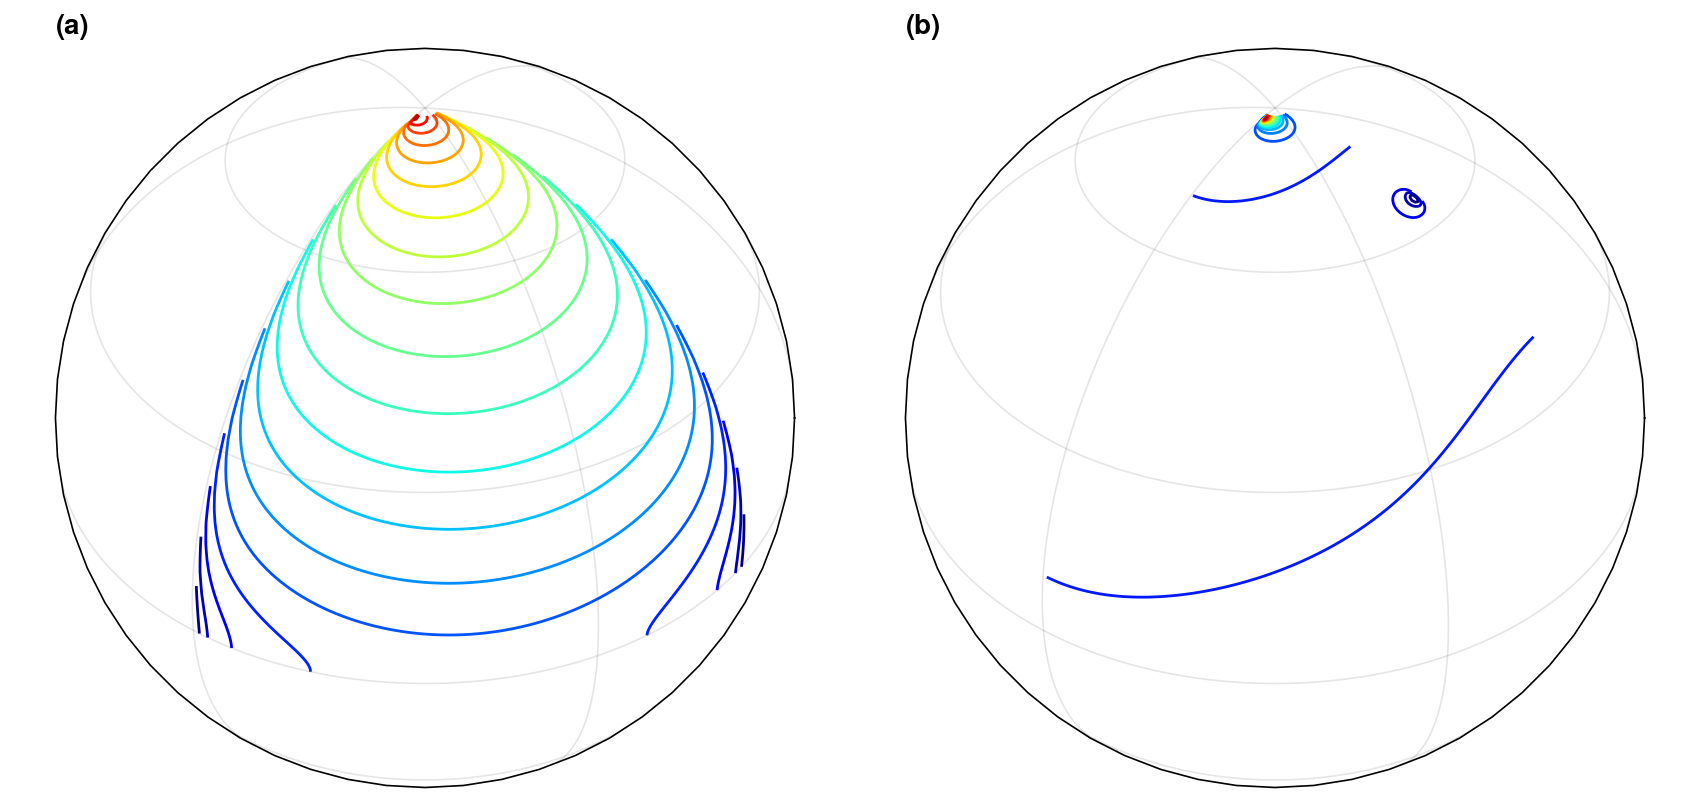

In [8]:
#%% plot wind and streamfunction
import proplot as pplt
import cartopy.crs as ccrs

fig, axes = pplt.subplots(nrows=1, ncols=2, figsize=(8.5,4), sharex=3, sharey=3,
                          #proj='geos', proj_kw={'central_longitude':165, 'central_latitude':55})
                          proj=ccrs.NearsidePerspective(central_latitude=40, central_longitude=155))
fontsize = 13

#
ax = axes[0]
ax.contour(np.log(h1), levels=21, lw=1, cmap='jet')
ax.pcolormesh(Q1.where(np.abs(Q1)>1e-4), levels=11)

ax = axes[1]
ax.contour(h2, levels=21, lw=1, cmap='jet')
ax.pcolormesh(Q2.where(np.abs(Q2)>1e-4), levels=11)

axes.format(abc='(a)')

In [190]:
# prepare for the inversion
iParams = {
    'BCs'      : ['extend', 'extend'],
    'mxLoop'   : 5000,
    'optArg'   : 1,
    'tolerance': 1e-18,
    'undef'    : np.nan,
}

eps = msrc - msrc + 8e-6 - (lons-120) * (8e-6-5e-7) / 90
eps = xr.where(basin, eps, np.nan)

mParams = {'epsilon': eps}

h1 = invert_StommelArons(msrc1, dims=['lat','lon'], iParams=iParams, mParams=mParams)
h2 = invert_StommelArons(msrc2, dims=['lat','lon'], iParams=iParams, mParams=mParams)
u1, v1 = cal_flow(h1, dims=['lat','lon'], BCs=['fixed', 'fixed'], vtype='GillMatsuno')
u2, v2 = cal_flow(h2, dims=['lat','lon'], BCs=['fixed', 'fixed'], vtype='GillMatsuno')

{} loops 5000 and tolerance is 1.211004e-04
{} loops 5000 and tolerance is 7.707715e-06


C:\ProgramData\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\ProgramData\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


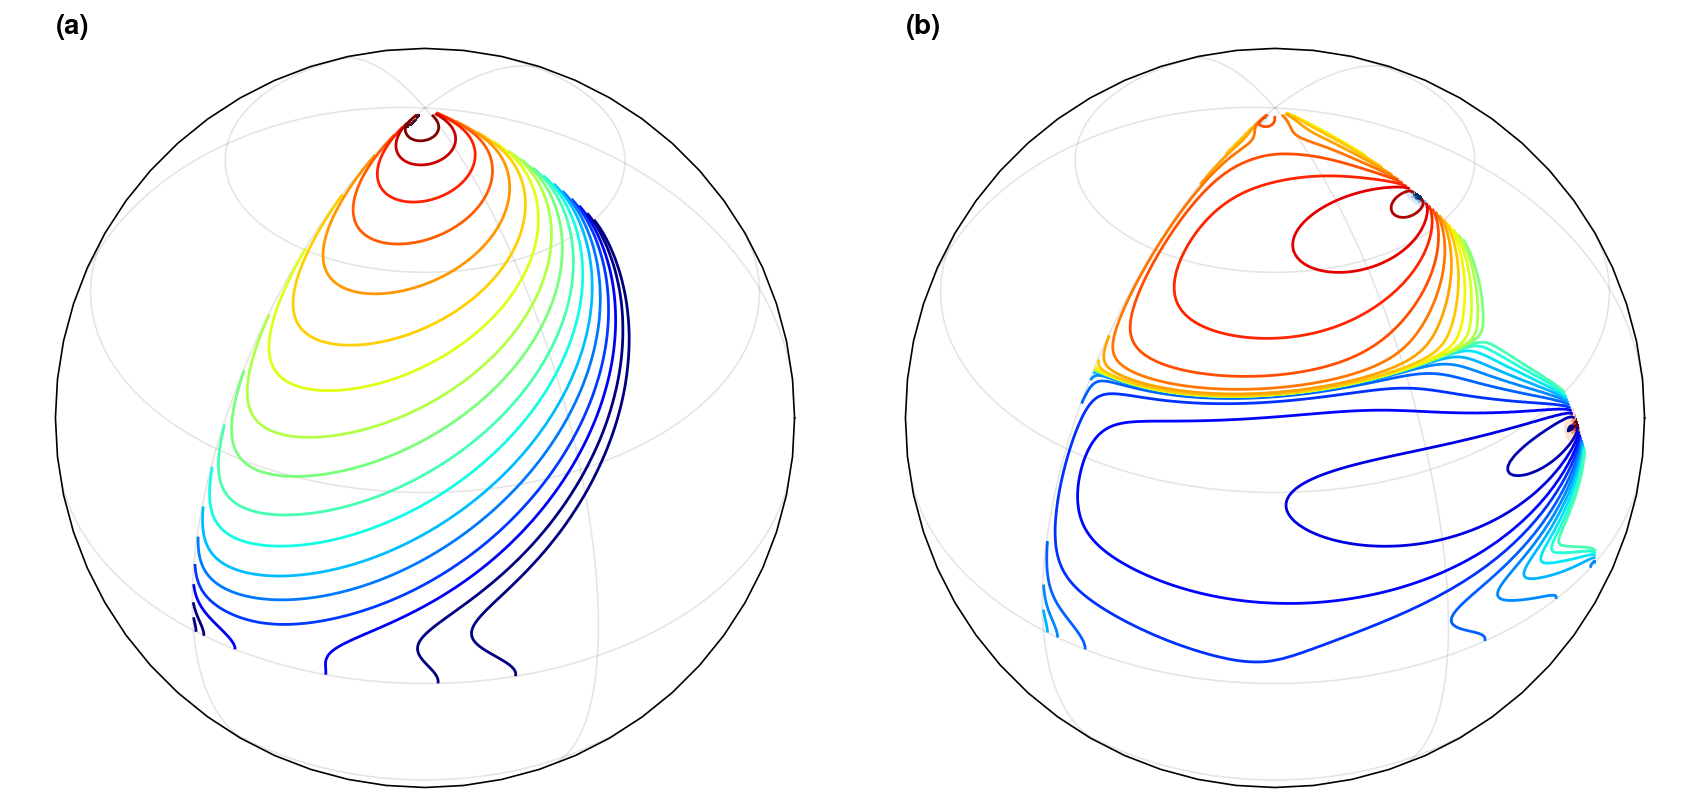

In [191]:
#%% plot wind and streamfunction
import proplot as pplt
import cartopy.crs as ccrs

fig, axes = pplt.subplots(nrows=1, ncols=2, figsize=(8.5,4), sharex=3, sharey=3,
                          #proj='geos', proj_kw={'central_longitude':165, 'central_latitude':55})
                          proj=ccrs.NearsidePerspective(central_latitude=40, central_longitude=155))
fontsize = 13

#
ax = axes[0]
ax.contour(h1, levels=[1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2,
                       0.1, 0.3, 1, 3, 10, 33, 100, 333, 1000], lw=1, cmap='jet')
ax.pcolormesh(msrc1.where(np.abs(msrc1)>1e-4), levels=11)

ax = axes[1]
ax.contour(h2, levels=[-3e5, -1e5, -3e4, -1e4, -3e3, -1e3, -3e2, -1e2, -33, -10, -3, -1,
                       1, 3, 10, 33, 100, 333, 1000, 3000, 1e4, 3e4, 1e5, 3e5], lw=1, cmap='jet')
ax.pcolormesh(msrc2.where(np.abs(msrc2)>1e-4), levels=11)

axes.format(abc='(a)')

Striking features are the weakening of the gyre circulation over the northern hemisphere in July and strengthening of the Somali jet over the Indian Ocean.

### 3.4 The global abyssal circulation case

Now we are moving onto the abyssal circulation case.  This is well demonstrated by [Stommel (1958)](https://www.sciencedirect.com/science/article/pii/S0146629158800144?via%3Dihub).  They assumed that there are several mass sources over the North Atlantic ocean and Ross Sea over the Antarctic, and everywhere else is uniform mass sink (upwelling).  This gives a steady abyssal circulation over the global oceans.

In [23]:
#%% classical cases for deep ocean circulation
import sys
sys.path.append('../../../')
import numpy as np
import xarray as xr
from xinvert import invert_StommelArons, cal_flow

def add_source(msrc, olon, olat, amp, rad):
    lons = msrc.lon
    lats = msrc.lat
    msrc += amp * np.exp(-((lats-olat)**2/rad + (lons-olon)**2/rad/3))

# mass source/sink over the global ocean
ds = xr.open_dataset('../../../../xinvert/Data/SODA_curl.nc')
msrc = (ds.curl-ds.curl)[0].load() # initialize with 0 over the ocean
msrc = xr.where(ds.bath< -1000, 0, np.nan) # maskout depth above 2000

add_source(msrc, 320,  57, -6e-3, 0.5) # source at the North Atlantic
add_source(msrc, 330, -73, -6e-3, 0.5) # sink at the Antarctic

# uniform upwelling sink
totalmsrc = (msrc*np.cos(np.deg2rad(msrc.lat))).sum()
totalarea = ((msrc-msrc+1)*np.cos(np.deg2rad(msrc.lat))).sum()
msrc = msrc - totalmsrc / totalarea
totalmsrc = (msrc*np.cos(np.deg2rad(msrc.lat))).sum()

# verify that the total source/sink should be close to zero
print(f'total mass source/sink: {totalmsrc.values}')

# prepare for the inversion
iParams = {
    'BCs'      : ['extend', 'periodic'],
    'mxLoop'   : 5000,
    'optArg'   : 1.2,
    'tolerance': 1e-18,
    'undef'    : np.nan,
}
mParams = {'epsilon': 1e-6}

h1 = invert_StommelArons(msrc, dims=['lat','lon'], iParams=iParams, mParams=mParams)
u1, v1 = cal_flow(h1, dims=['lat','lon'], BCs=['extend', 'periodic'], vtype='GillMatsuno')

total mass source/sink: 1.0408340855860843e-17
{} loops 5000 and tolerance is 4.576002e-09


C:\ProgramData\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


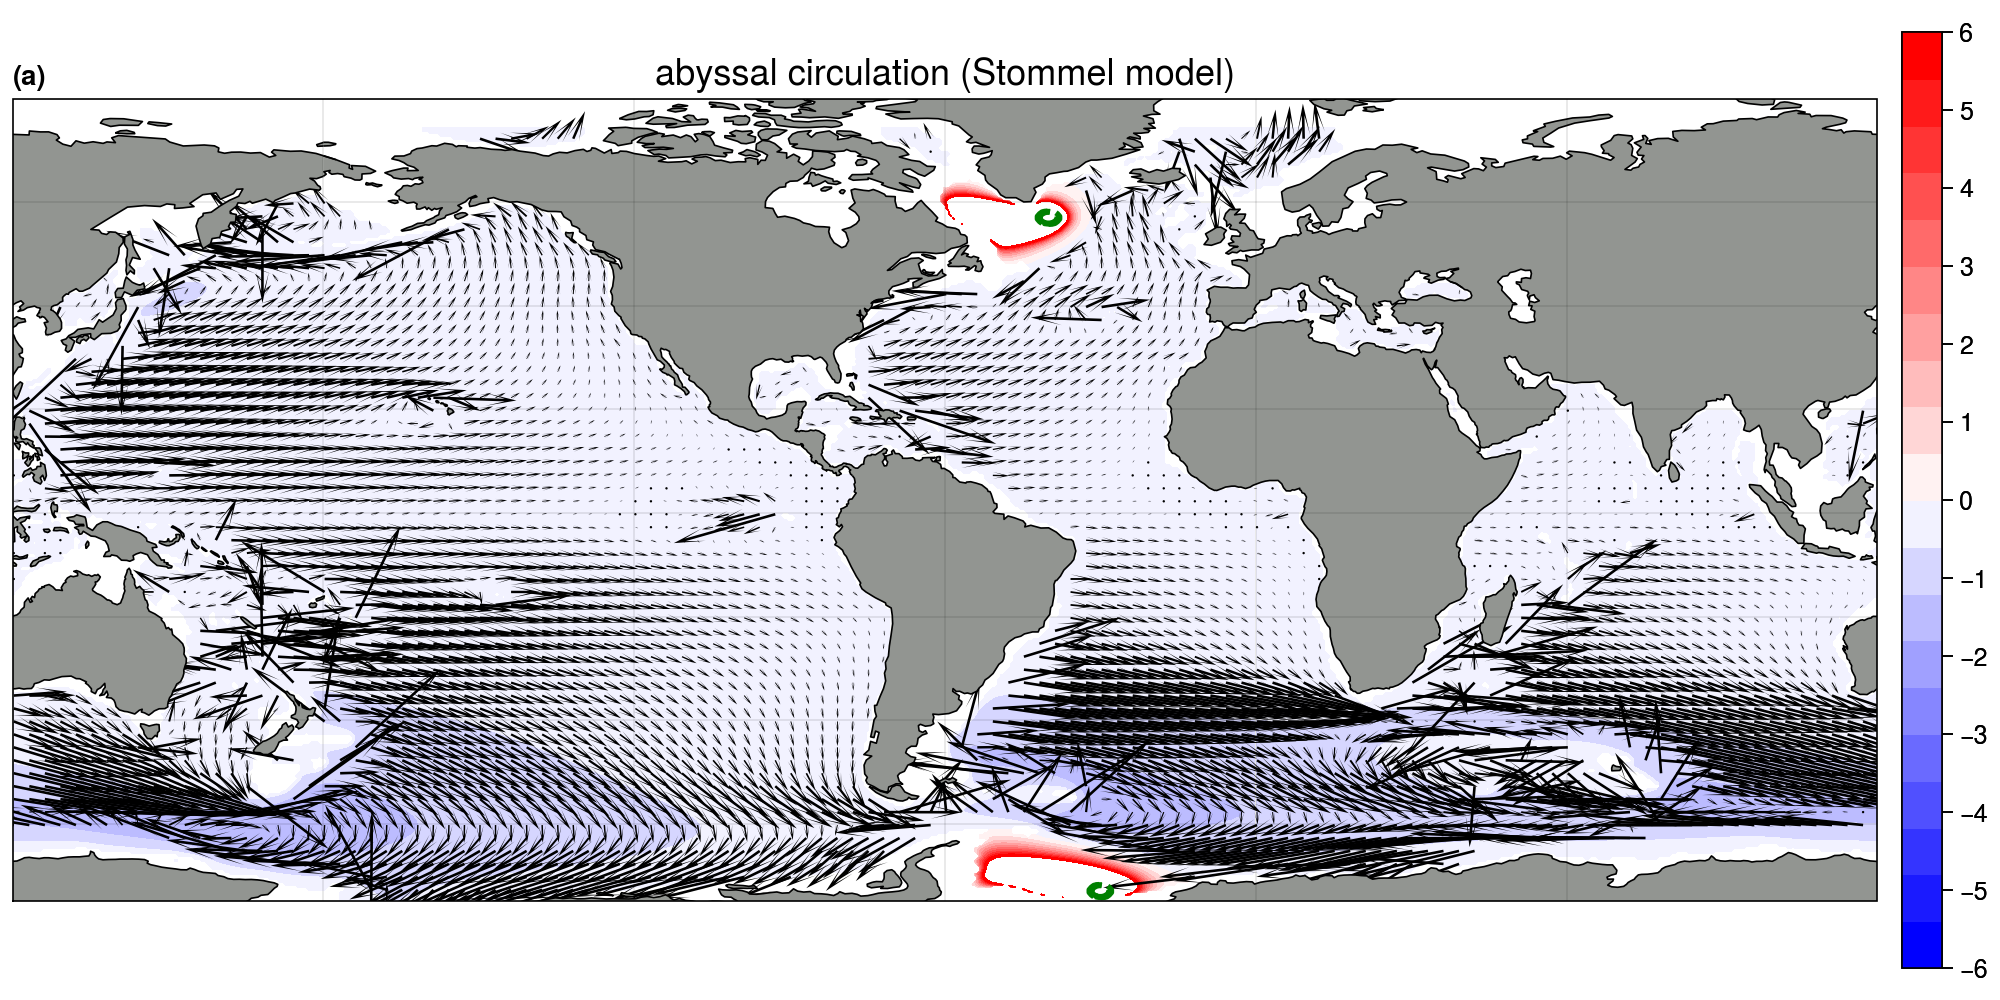

In [36]:
#%% plot wind and streamfunction
import proplot as pplt

fig, axes = pplt.subplots(nrows=1, ncols=1, figsize=(10,5), sharex=3, sharey=3,
                          proj='cyl', proj_kw={'central_longitude':300})
skip = 5
fontsize = 13

ygrid, xgrid = xr.broadcast(msrc.lat, msrc.lon)

mag = (u1**2 + v1**2) / 2

ax = axes[0]
m = ax.contourf(h1/3000, levels=np.linspace(-6, 6, 21), cmap='bwr')
ax.contour(msrc, levels=[-0.0008, -0.0005, -0.0003, 0.0003, 0.0005, 0.0008], lw=2, color='g')
ax.quiver(xgrid.values[::skip,::skip+1], ygrid.values[::skip,::skip+1],
          u1.where(mag<5e2).values[::skip,::skip+1], v1.values[::skip,::skip+1],
          width=0.0014, headwidth=5., headlength=12., scale=500)
ax.set_ylabel('longitude', fontsize=fontsize-1)
ax.set_xlabel('latitude', fontsize=fontsize-1)
ax.set_title('abyssal circulation (Stommel model)', fontsize=fontsize)

fig.colorbar(m, loc='r', label='', length=0.96, ticks=1)
axes.format(abc='(a)', land=True, coast=True, landcolor='gray', latlim=[-75, 80])

---

### References
1. Stommel, H., 1958: [The abyssal circulation](https://www.sciencedirect.com/science/article/pii/S0146629158800144?via%3Dihub). *Deep Sea Res.*, **5**, 80-82.
2. Stommel, H, and A. B. Arons, 1960: [On the abyssal circulation of the world ocean - I. Stationary planetary flow patterns on a sphere](https://www.sciencedirect.com/science/article/abs/pii/0146631359900656), *Deep Sea Research*, **6**, 140-154.
3. Stommel, H, and A. B. Arons, 1960: [On the abyssal circulation of the world ocean - II. An idealized model of the circulation pattern and amplitude in oceanic basins](https://www.sciencedirect.com/science/article/abs/pii/0146631359), *Deep Sea Research*, **6**, 217-218.